1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

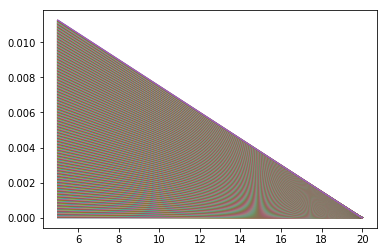

In [35]:
import numpy as np
import matplotlib.pyplot as plt

t=np.arange(0.001,1,0.001)
poissons_ratio = 0.20
E = 0.2 
Inner_radius = 5
outer_radius = 20
n = 1
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.01
yield_stress = 200e-6 #N/micromm^2
C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])
coordinate = np.linspace(Inner_radius,outer_radius,n+1)
#print(coordinate)

Global_K = np.zeros((n+1,n+1))   # Zero matrix of order (n+1,n+1) for adding elemental stiffness
Global_F_ext = np.zeros((n+1,1))
delta_u = 1

plastic_strain = np.zeros((n,3,1))

d = np.linspace(0,(1/3*t[0]*(-volumetric_strain)*coordinate[0]),n+1).reshape(n+1,1) #Initial guess
  
Global_displacement = np.flip(d,0)   
#print(Global_displacement)
Reduced_displacement = np.delete(Global_displacement,(0),axis=0)


for time,tau in enumerate(t):
    Global_displacement[0]=1/3*tau*(-volumetric_strain)*Inner_radius
    print(time+1)
    for i in range(len(coordinate)-1):
      
        
        def element_routine(coordinate,Lambda,mu,tau):
            Derivative_N = np.array([-1/2,1/2])
            Jacobian = Derivative_N@np.array([[coordinate[i]],
                                              [coordinate[i+1]]])
            J_inv = np.asscalar(1/Jacobian)

            B = np.array([[-1/2*J_inv,1/2*J_inv],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])

            
            B_T = np.transpose(B)
            Element_stiffness = 2*(B_T@material_routine(E)@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2
            
            #External force calculation
            sigma_rr = 2*mu*J_inv*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain

            Fe = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                            [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
            return Element_stiffness,Fe
        
        
        def material_routine(E):
            Derivative_N = np.array([-1/2,1/2])
            Jacobian = Derivative_N@np.array([[coordinate[i]],
                                              [coordinate[i+1]]])
            J_inv = np.asscalar(1/Jacobian)

            B_matrix = np.array([[-1/2*J_inv,1/2*J_inv],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])
            
            Current_strain = B_matrix@np.array([Global_displacement[i],Global_displacement[i+1]]) 
           
            
            Trial_stress = C@(Current_strain - plastic_strain[i])
            Trial_dev = Trial_stress - 1/3*np.sum(Trial_stress)
            Trial_eq = np.sqrt(3/2*(np.sum(np.square(Trial_dev))))
            
            if Trial_eq - yield_stress <= 0:
                return C
            else:
                del_lamda = (Trial_eq - yield_stress)/E
                plastic_strain[i] = plastic_strain[i] + del_lamda * 1.5 * (Trial_dev/Trial_eq)
                new_stress = C@(Current_strain-plastic_strain[i])
                
        
        Ke,Fe_ext = element_routine(coordinate,Lambda,mu,tau) 

        #Assignmnet matrix
        Ae = np.zeros((2,n+1))
        Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
        Ae[1,i+1]  =1
        AeT = np.transpose(Ae)

       
        #Global stiffness matrix
        K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
        Global_K = np.add(Global_K,K)                        # Global stiffnes matrix
        K_red = np.delete(Global_K,(0),axis=0)
        K_red = np.delete(K_red,(0),axis=1)



        F_ext = AeT@Fe_ext                                   # Force vector of each element after transformation
        Global_F_ext=np.add(Global_F_ext,F_ext)              # Global F matrix
        Global_F_ext[-1]=0                                   # Global F matrix
        



    
    #Newton Raphson method
    while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Reduced_displacement)):

        G_matrix = Global_K@Global_displacement - Global_F_ext
        G_red = np.delete(G_matrix,(0),axis=0)
        delta_u = np.linalg.inv(K_red)@G_red
        Reduced_displacement = Reduced_displacement - delta_u
        Global_displacement = np.insert(Reduced_displacement,(0),(1/3*(tau)*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
    plt.plot(coordinate,Global_displacement)
    
coordinate = coordinate + (Global_displacement.reshape(1,n+1))
    
 



       
   
   
    